In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [3]:
cd /content/drive/MyDrive/aiffel/data/segmentation

/content/drive/MyDrive/aiffel/data/segmentation


In [ ]:
!wget https://www.dropbox.com/s/thhq5312hdwo494/KITTI.zip
!unzip KITTI.zip

--2022-04-08 08:44:11--  https://www.dropbox.com/s/thhq5312hdwo494/KITTI.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/thhq5312hdwo494/KITTI.zip [following]
--2022-04-08 08:44:12--  https://www.dropbox.com/s/raw/thhq5312hdwo494/KITTI.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1b7604473a13245e5b4cf06c1f.dl.dropboxusercontent.com/cd/0/inline/Bi_jTenAmu80OZn1dHMQIVV3zNmJJ76F8ApLcUI2Adsqxw9OKAly0tjMn5Rt216_1EBzk9MqHO_N_hH3wtjYYrzA-qqtXJbcmdr2muxeiGKmILPkM2H8optDu71WYBqmvWTQxcEiEryJJaCaT6acZsTILyLeoxkV2YQZXLXneCUdrg/file# [following]
--2022-04-08 08:44:12--  https://uc1b7604473a13245e5b4cf06c1f.dl.dropboxusercontent.com/cd/0/inline/Bi_jTenAmu80OZn1dHMQIVV3zNmJJ76F8ApLcUI2Adsqxw9OKAly0tjMn5Rt216_1EBzk9MqHO_N_

In [4]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

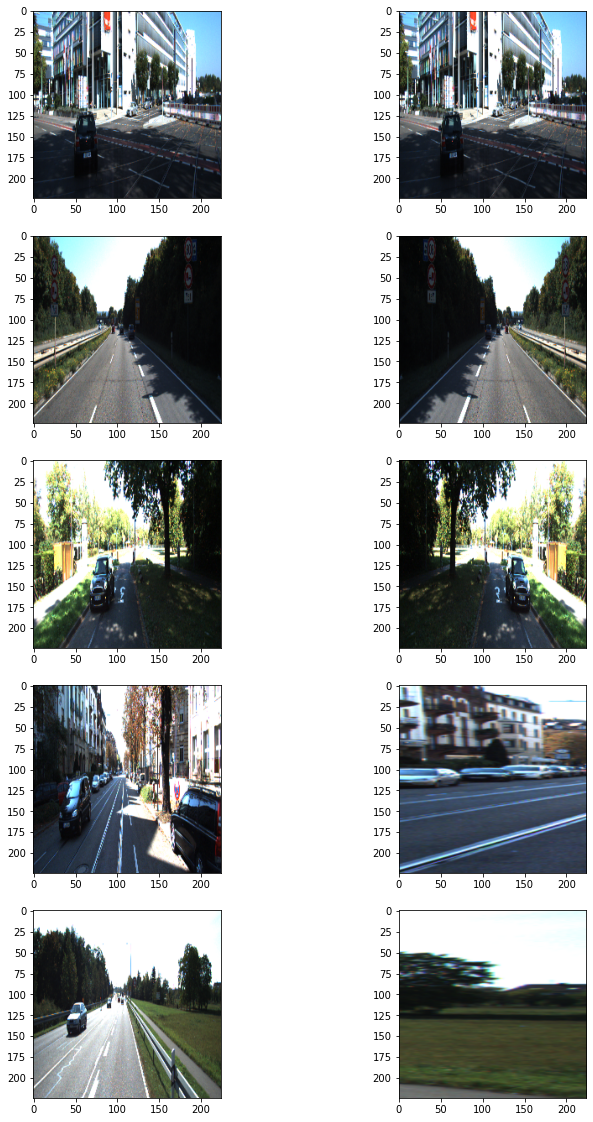

In [7]:
dir_path = '/content/drive/MyDrive/aiffel/data/segmentation/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [5]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [8]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# 모델 구조 만들기(U-Net)

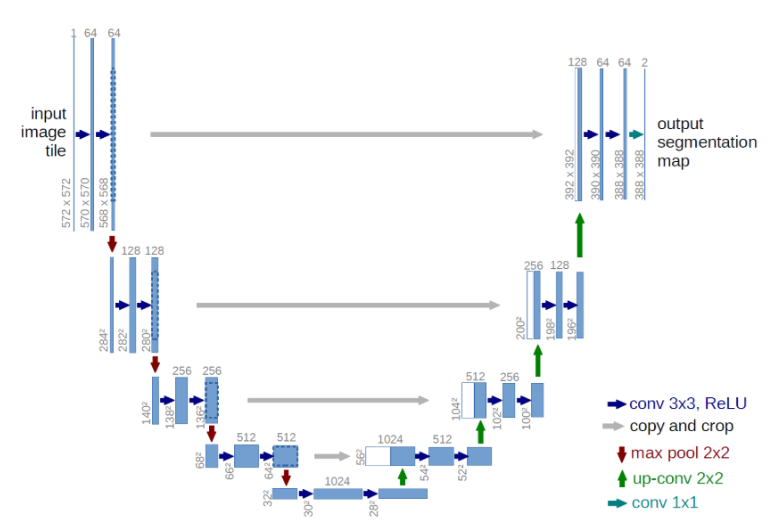

- 기존 U-Net 구조는 padding없이 진행되어 input에 비해 output의 사이즈가 줄어든다. 이를 방지하기 위해 padding을 same으로 두는 약간 다른 UNet인데 이를 UNet++에도 똑같이 적용한다.
(UNet++을 위해 일부로 이렇게 모델을 구성해준 것 같다.)

In [9]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    
    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [ ]:
model_path = '/content/drive/MyDrive/aiffel/data/segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
 1/11 [=>............................] - ETA: 14:40 - loss: 0.6923

In [16]:
model = build_model()
model_path = '/content/drive/MyDrive/aiffel/data/segmentation/training/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

In [55]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output 

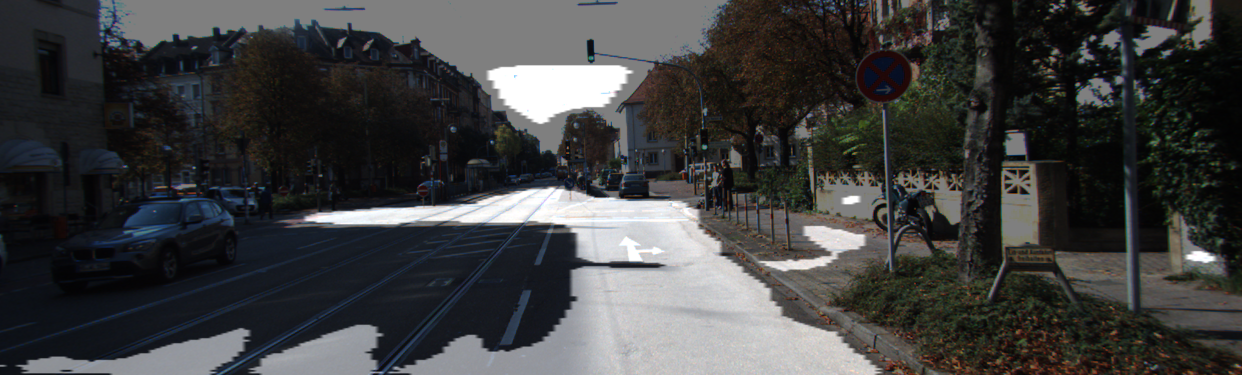

In [56]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [22]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [23]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  
    #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라짐.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [25]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.419641


0.41964089410040306

# U-Net++ 모델의 구현

참고 : https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py

In [27]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.8.0
1.21.5
7.1.2
0.18.3
0.1.12


In [26]:
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import * 

In [28]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
    batch_size=4
)


test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False,
    batch_size=4
)

In [43]:

def conv_block(filters, inputs, pooling=False):
    if pooling:
        x = MaxPooling2D(2, 2)(inputs)
    else:
        x = inputs
    x = Conv2D(filters, (3,3), activation='relu', padding='same',kernel_initializer='he_normal')(x)
    x = Conv2D(filters, (3,3), activation='relu', padding='same',kernel_initializer='he_normal')(x)
    # if pooling:
    #     x = MaxPooling2D(pool_size=(2, 2))(x)
    
    return x


def skip_block(filters, inputs):
    x = Conv2D(filters, (1,1), activation='relu', kernel_initializer='he_normal')(inputs)
    return x

def up_block(filters, inputs):
    x = Conv2DTranspose(filters, 2, (2, 2), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    return x

### Pooling 순서를 바꿔줘야함.
노드 내에서 끝나는 상태는 conv시행까지다. 다시 말해, pooling이 뒤에 있을 경우 화살표 하나를 진행한 것이 되어 이미 넘어간 상태가 된다.

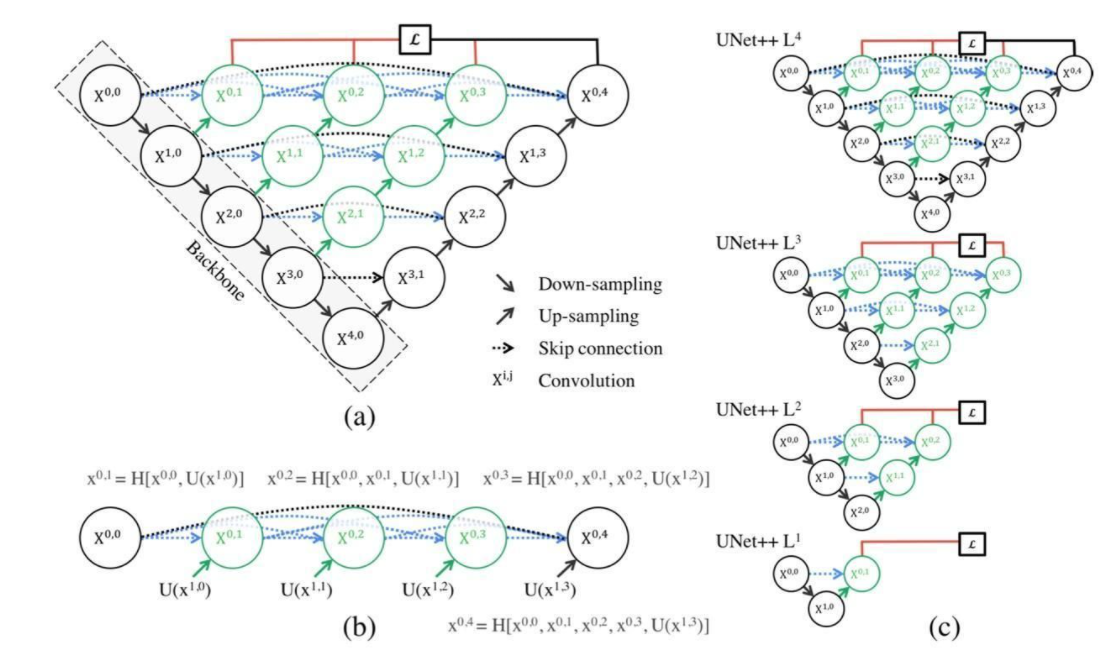

- 원(노드)는 컨볼루션 2겹의 conv레이어.
- 대각선 아래는 maxpooling2D
- 대각선 위로는 Conv2DTranspose
- 점선은 Skip connection. 
- Skip connection들이 UNet++ 에서는 조합의 형태로 이어짐. ex) X0,4에 대해서 모이는 값들은 [ X00,01,02,03,Upsampling(X13) ] 이다.

In [84]:
def UNetPlusPlus(num_classes=1, input_shape=(224,224,3), deep_supervision=True):

    inputs = Input(input_shape)
    
    # x_,0
    #in
    X0_0 = conv_block(64, inputs)
    X1_0 = conv_block(128, X0_0, pooling=True)
    X2_0 = conv_block(256, X1_0, pooling=True)
    X3_0 = conv_block(512, X2_0, pooling=True)
    X4_0 = conv_block(1024, X3_0, pooling=True)
    #out
    X0_0_skip = skip_block(X0_0.shape[3], X0_0)
    X1_0_skip = skip_block(X1_0.shape[3], X1_0)
    X2_0_skip = skip_block(X2_0.shape[3], X2_0)
    X3_0_skip = skip_block(X3_0.shape[3], X3_0)

    X1_0_up = up_block(X1_0.shape[3]/2, X1_0)
    X2_0_up = up_block(X2_0.shape[3]/2, X2_0)
    X3_0_up = up_block(X3_0.shape[3]/2, X3_0)
    X4_0_up = up_block(X4_0.shape[3]/2, X4_0)

    # x_.1 
    #in
    M0_1 = concatenate([X0_0_skip, X1_0_up], axis=3)
    M1_1 = concatenate([X1_0_skip, X2_0_up], axis=3)
    M2_1 = concatenate([X2_0_skip, X3_0_up], axis=3)
    M3_1 = concatenate([X3_0_skip, X4_0_up], axis=3)

    X0_1 = conv_block(64, M0_1, pooling=False) # output1
    X1_1 = conv_block(128, M1_1, pooling=False)
    X2_1 = conv_block(256, M2_1, pooling=False)
    X3_1 = conv_block(512, M3_1, pooling=False)  
    #out
    X1_1_up = up_block(X1_1.shape[3]/2, X1_1)
    X2_1_up = up_block(X2_1.shape[3]/2, X2_1)
    X3_1_up = up_block(X3_1.shape[3]/2, X3_1)

    X0_1_skip = skip_block(X0_0.shape[3], X0_1)
    X1_1_skip = skip_block(X1_0.shape[3], X1_1)
    X2_1_skip = skip_block(X2_0.shape[3], X2_1)

    # x_,2
    #in
    M0_2 = concatenate([X0_0_skip, X0_1_skip, X1_1_up], axis=3)
    M1_2 = concatenate([X1_0_skip, X1_1_skip, X2_1_up], axis=3)
    M2_2 = concatenate([X2_0_skip, X2_1_skip, X3_1_up], axis=3)

    X0_2 = conv_block(64, M0_2, pooling=False) #output2
    X1_2 = conv_block(128, M1_2, pooling=False)
    X2_2 = conv_block(256, M2_2, pooling=False)
    #out
    X0_2_skip = skip_block(X0_0.shape[3], X0_2)
    X1_2_skip = skip_block(X1_0.shape[3], X1_2)

    X1_2_up = up_block(X1_2.shape[3]/2, X1_2)
    X2_2_up = up_block(X2_2.shape[3]/2, X2_2)

    # x_,3
    #in
    M0_3 = concatenate([X0_0_skip, X0_1_skip, X0_2_skip, X1_2_up], axis=3)
    M1_3 = concatenate([X1_0_skip, X1_1_skip, X1_2_skip, X2_2_up], axis=3)

    X0_3 = conv_block(64, M0_3, pooling=False) #output3
    X1_3 = conv_block(128, M1_3, pooling=False)
    #out
    X0_3_skip = skip_block(X0_0.shape[3], X0_3)

    X1_3_up = up_block(X1_3.shape[3]/2, X1_3)

    # x_,4
    #in = output4
    M0_4 = concatenate([X0_0_skip, X0_1_skip, X0_2_skip, X0_3_skip, X1_3_up], axis=3)
    X0_4 = conv_block(64, M0_4, pooling=False)


    # Deep Supervision
    output1 = Conv2D(num_classes, (1, 1), activation='sigmoid', name='output1', kernel_initializer = 'he_normal', padding='same')(X0_1)
    output2 = Conv2D(num_classes, (1, 1), activation='sigmoid', name='output2', kernel_initializer = 'he_normal', padding='same')(X0_2)
    output3 = Conv2D(num_classes, (1, 1), activation='sigmoid', name='output3', kernel_initializer = 'he_normal', padding='same')(X0_3)
    output4 = Conv2D(num_classes, (1, 1), activation='sigmoid', name='output4', kernel_initializer = 'he_normal', padding='same')(X0_4)

    if deep_supervision:
        model = Model(inputs=inputs, outputs = [output1, output2, output3, output4])
    
    else:
        model = Model(inputs=inputs, outputs = output4)


    return model

   

In [85]:
unetpp_model = UNetPlusPlus(deep_supervision=False)
unetpp_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_170 (Conv2D)            (None, 224, 224, 64  1792        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_171 (Conv2D)            (None, 224, 224, 64  36928       ['conv2d_170[0][0]']             
                                )                                                           

In [86]:
# 테스트 케이스 만들기
shape = (224, 224, 3)
test_input = tf.random.normal(shape)
test_input = tf.expand_dims(test_input, axis=0)

test_output_1 = unetpp_model(test_input)
print(f"unetpp : {np.array(test_output_1).shape}")

unetpp : (1, 224, 224, 1)


In [87]:
unetpp_model_path = '/content/drive/MyDrive/aiffel/data/segmentation/training/model_unetpp.h5'

#model = build_model()
unetpp_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
unetpp_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(unetpp_model_path)

Epoch 1/100
43/43 [==============================] - 14s 267ms/step - loss: 0.4149 - val_loss: 0.1133
Epoch 2/100
43/43 [==============================] - 11s 256ms/step - loss: 0.1882 - val_loss: 0.1544
Epoch 3/100
43/43 [==============================] - 11s 256ms/step - loss: 0.1456 - val_loss: 0.0931
Epoch 4/100
43/43 [==============================] - 11s 256ms/step - loss: 0.1098 - val_loss: 0.0717
Epoch 5/100
43/43 [==============================] - 11s 256ms/step - loss: 0.0877 - val_loss: 0.0625
Epoch 6/100
43/43 [==============================] - 11s 256ms/step - loss: 0.0741 - val_loss: 0.0987
Epoch 7/100
43/43 [==============================] - 11s 256ms/step - loss: 0.0665 - val_loss: 0.0667
Epoch 8/100
43/43 [==============================] - 11s 256ms/step - loss: 0.0555 - val_loss: 0.0888
Epoch 9/100
43/43 [==============================] - 11s 256ms/step - loss: 0.0560 - val_loss: 0.1104
Epoch 10/100
43/43 [==============================] - 11s 256ms/step - loss: 0.055

 # U-Net 과 U-Net++의 세그멘테이션 결과 분석

In [100]:
# 예측값 이미지 뽑아내는 함수 만들기
def get_output(model, preproc, image_path, label_path, deep_supervision):
    origin_img = skimage.io.imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    if deep_supervision:
        output = tf.reduce_mean(output, axis=0)
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255   # 배치사이즈 차원 벗기기(output[0]), 3차원 -> 2차원 만들기 squeeze : (224, 224, 1) -> (224, 224)
    prediction = output/255   # 0 ~ 1 사이 확률로 다시 만들어주기
    
    output = PIL.Image.fromarray(output)
    background = PIL.Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = PIL.Image.blend(background, output, alpha=0.5)
    output.show()   # 작동 안 함

    if label_path:   
        label_img = skimage.io.imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역
        target_for_print = PIL.Image.fromarray(target)
        target_for_print = target_for_print.resize((origin_img.shape[1], origin_img.shape[0]))

        return output, prediction, target, target_for_print
    else:
        return output, prediction, _1, _2

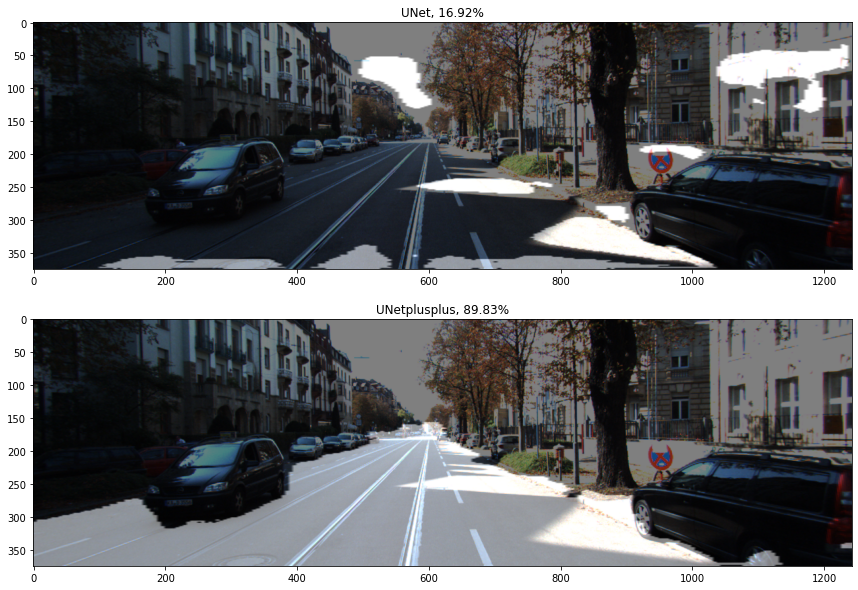

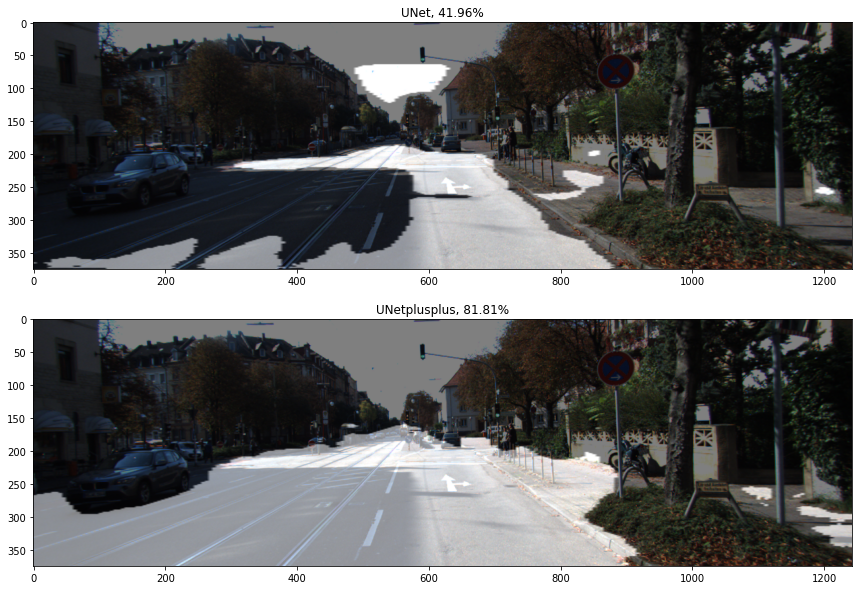

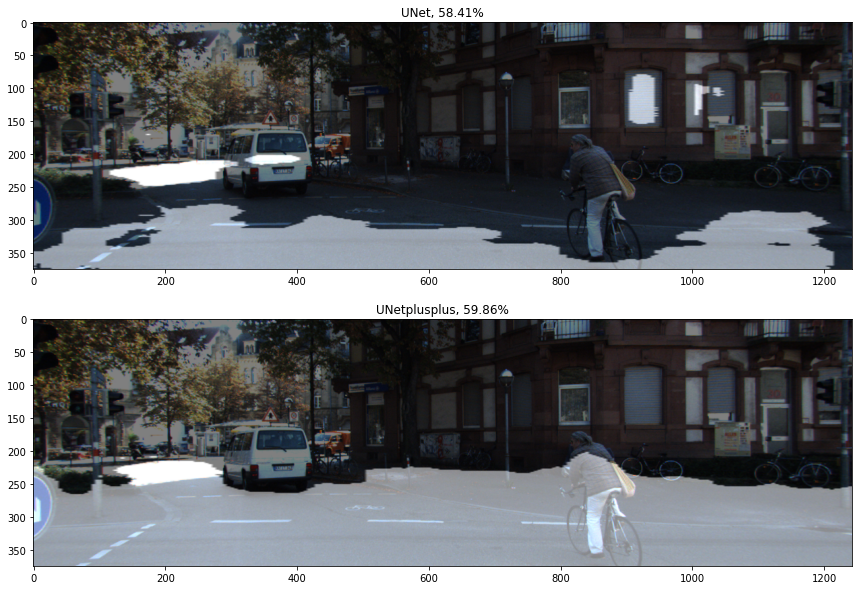

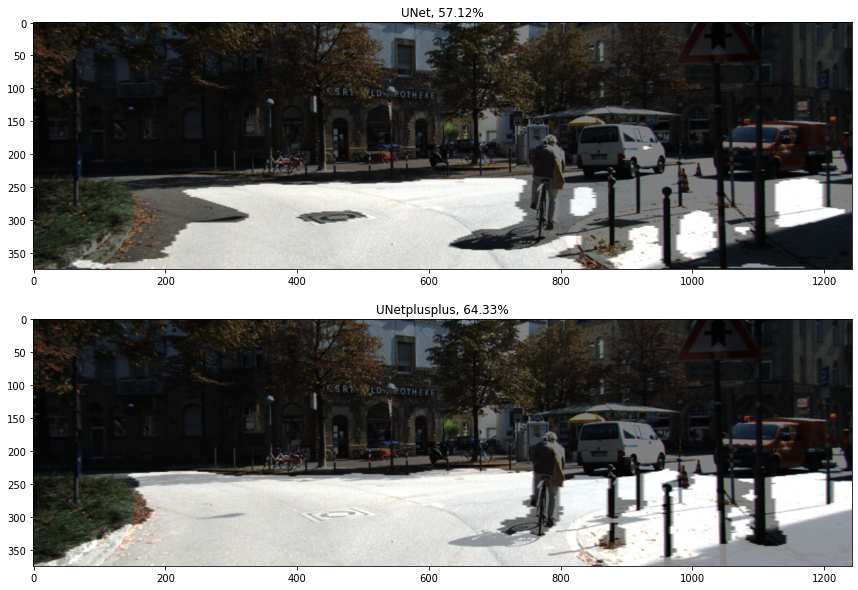

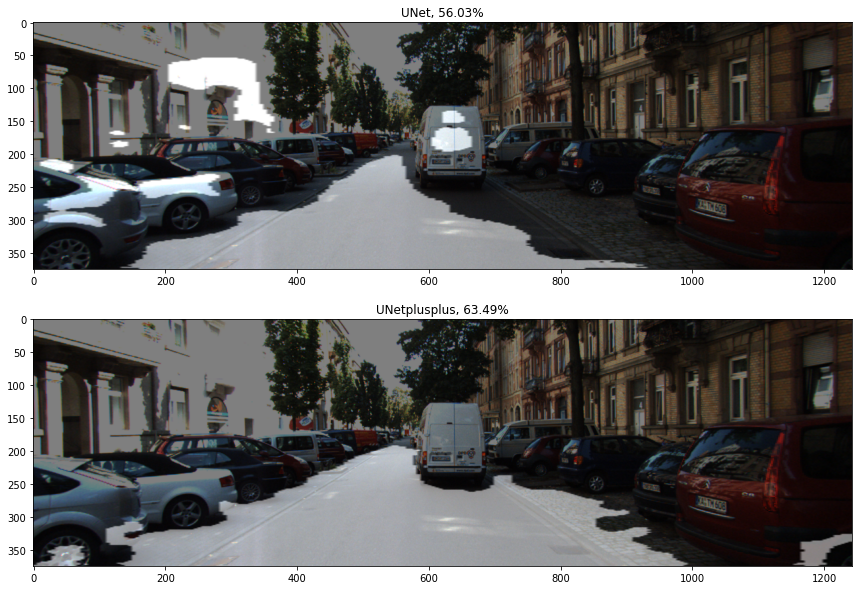

In [104]:
for i in range(5):
    output_1, prediction_1, target, target_for_print = get_output(model, test_preproc, image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png', label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png', deep_supervision=False)
    iou_score_1 = calculate_iou_score(target, prediction_1)
    output_2, prediction_2, target, target_for_print = get_output(unetpp_model, test_preproc, image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png', label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png', deep_supervision=False)
    iou_score_2 = calculate_iou_score(target, prediction_2)

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.imshow(output_1)
    plt.axis=('off')
    plt.title(f"UNet, {iou_score_1 * 100 :.2f}%")

    plt.subplot(2, 1, 2)
    plt.imshow(output_2)
    plt.axis=('off')
    plt.title(f"UNetplusplus, {iou_score_2 * 100 :.2f}%")
    
    plt.show()
    print("==============")
    print("==============")

# 결과 및 회고
IoU 결과 값

||UNet|UNet++|
|:---|---|---|
|1|16.92|89.93|
|2|41.96|81.81|
|3|58.41|59.86|
|4|57.12|64.33|
|5|56.03|63.49|

살펴본 5개의 testset에서 UNet++가 더 좋은 결과를 냈다.

- skip connection 부분에서 conv1,1을 지나가는 것에 차이가 있다고 착각하여 불필요한 레이어 함수를 집어넣었다.
- 도식화를 바탕으로 완전 동일하게 모델을 구현한 부분은 뿌듯했다.
- 하지만, 논문에서 deep supervison에 대한 부분도 구현하기는 했으나, loss 계산법이나 output이 4개가 나오는 것을 처리하여 이를 출력하는 방법을 찾지 못했다. loss에 대한 부분은 더 공부해서 이해하고 넘어가고 싶다.(datatype오류가 계속 떴다.)


#참고

https://github.com/yihangx/Unetplusplus/blob/master/Unet%2B%2B.ipynb
https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py
https://wsshin.tistory.com/2
https://m.blog.naver.com/j005580/221882044894



